- [Предобработка](#Предобработка)
- [Label Encoding категориальных и ранговых признаков](#Label-Encoding-категориальных-и-ранговых-признаков)
- [Label Encoding ранговых и One-Hot Encoding категориальных признаков](#Label-Encoding-ранговых-и-One-Hot-Encoding-категориальных-признаков)
- [One-Hot Encoding категориальных и ранговых признаков](#One-Hot-Encoding-категориальных-и-ранговых-признаков)
- [Multi-Class Target Encoding категориальных и Label Encoding ранговых признаков](#Multi-Class-Target-Encoding-категориальных-и-Label-Encoding-ранговых-признаков)
- [Multi-Class Target Encoding категориальных и ранговых признаков](#Multi-Class-Target-Encoding-категориальных-и-ранговых-признаков)

In [1]:
import os
import subprocess

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from utils import definitions as defs

In [2]:
RANDOM_STATE = 42
TRAIN_SIZE = 0.7

In [3]:
df = pd.read_excel(defs.ETLED_DATA_PATH)

## Предобработка

In [4]:
y = df[defs.TARGET]
X = df.drop(defs.TARGET, axis=1)

In [5]:
feature_names = list(X)

Меняем NaN на -1 в численных признаках.

In [6]:
X.replace({
    defs.QUESTION_2: {np.NaN: -1},
    defs.QUESTION_4: {np.NaN: -1},
    defs.QUESTION_22: {np.NaN: -1},
    defs.QUESTION_24: {np.NaN: -1},
}, inplace=True)

Label Encoding ранговых признаков.

In [7]:
X.replace({
    defs.QUESTION_5:
    {
        np.NaN: -1,
        defs.ANSWER_5_5: 0,
        defs.ANSWER_5_4: 1,
        defs.ANSWER_5_3: 2,
        defs.ANSWER_5_2: 3,
        defs.ANSWER_5_1: 4,
    },
    defs.QUESTION_7:
    {
        np.NaN: -1,
        defs.ANSWER_7_6: 0,
        defs.ANSWER_7_5: 1,
        defs.ANSWER_7_4: 2,
        defs.ANSWER_7_3: 3,
        defs.ANSWER_7_2: 4,
        defs.ANSWER_7_1: 5,
    },
    defs.QUESTION_9:
    {
        np.NaN: -1,
    },
    defs.QUESTION_11:
    {
        np.NaN: -1,
        defs.ANSWER_11_6: 0,
        defs.ANSWER_11_5: 1,
        defs.ANSWER_11_4: 2,
        defs.ANSWER_11_3: 3,
        defs.ANSWER_11_2: 4,
        defs.ANSWER_11_1: 5,
    },
    defs.QUESTION_12:
    {
        np.NaN: -1,
        defs.ANSWER_12_1: 0,
        defs.ANSWER_12_2: 1,
        defs.ANSWER_12_3: 2,
        defs.ANSWER_12_4: 3,
    },
    defs.QUESTION_13:
    {
        np.NaN: -1,
        defs.ANSWER_13_5: 0,
        defs.ANSWER_13_4: 1,
        defs.ANSWER_13_6: 2,
        defs.ANSWER_13_7: 3,
        defs.ANSWER_13_3: 4,
        defs.ANSWER_13_2: 5,
        defs.ANSWER_13_1: 6,
    },
    defs.QUESTION_14:
    {
        np.NaN: -1,
        defs.ANSWER_14_4: 0,
        defs.ANSWER_14_3: 1,
        defs.ANSWER_14_2: 2,
        defs.ANSWER_14_1: 3,
    },
    defs.QUESTION_16:
    {
        np.NaN: -1,
    },
    defs.QUESTION_17:
    {
        np.NaN: -1,
    },
    defs.QUESTION_18:
    {
        np.NaN: -1,
    },
    defs.QUESTION_19:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    },
    defs.QUESTION_20:
    {
        np.NaN: -1,
        defs.ANSWER_19_20_1: 0,
        defs.ANSWER_19_20_2: 1,
        defs.ANSWER_19_20_3: 2,
        defs.ANSWER_19_20_4: 3,
    },
    defs.QUESTION_26:
    {
        np.NaN: -1,
        defs.ANSWER_26_1: 0,
        defs.ANSWER_26_2: 1,
        defs.ANSWER_26_3: 2,
    },
    defs.QUESTION_27:
    {
        np.NaN: -1,
        defs.ANSWER_27_4: 0,
        defs.ANSWER_27_3: 1,
        defs.ANSWER_27_2: 2,
        defs.ANSWER_27_1: 3,
    },
    defs.QUESTION_28:
    {
        np.NaN: -1,
        defs.ANSWER_28_4: 0,
        defs.ANSWER_28_3: 1,
        defs.ANSWER_28_2: 2,
        defs.ANSWER_28_1: 3,
    },
    defs.QUESTION_29:
    {
        np.NaN: -1,
        defs.ANSWER_29_4: 0,
        defs.ANSWER_29_3: 1,
        defs.ANSWER_29_2: 2,
        defs.ANSWER_29_1: 3,
    },
}, inplace=True)

X[defs.QUESTION_9] = X[defs.QUESTION_9].astype('int64')

Кодируем бинарные признаки.

In [8]:
for feature in defs.BINARY_FEATURES:
    if X[feature].isna().sum():
        X[feature].replace({np.NaN: -1}, inplace=True)
    X[feature].replace({defs.YES: 1, defs.NO: 0}, inplace=True)

## Label Encoding категориальных и ранговых признаков

In [9]:
def encode_categorical_feature(df, feature, categories):
    # Столбец в DataFrame становится "категориальным". Это означает, что ячейки в нём могут
    # принимать только значения из допустимых категорий либо np.NaN. Допустимые категории
    # определяются при создании такого столбца либо множеством различных ячеек, либо
    # специальным списком. Если допустимые категории определяются специальным списком и 
    # значение ячейки не входит в этот список, её значение становится np.NaN.
    df[feature] = pd.Categorical(df[feature], categories=categories)
    # Категории кодируются числами 0, 1, 2, ... np.NaN числом -1.
    df[feature] = df[feature].cat.codes
    # Приведение к типу, допустимому для конвертации DataFrame в Dataset.
    df[feature] = df[feature].astype('int64')

In [10]:
X_LE = X.copy()

for feature, categories in defs.CATEGORICAL_FEATURES.items():
    encode_categorical_feature(X_LE, feature, categories)

In [11]:
X_LE_train, X_LE_test, y_train, y_test = train_test_split(
    X_LE, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [12]:
PARAM_GRID = [
    {
        'min_samples_split': [2],
        'min_samples_leaf': [1],
    },
    {
        'min_samples_split': [4],
        'min_samples_leaf': [1, 2],
    },
    {
        'min_samples_split': [8],
        'min_samples_leaf': [1, 2, 4],
    },
    {
        'min_samples_split': [16],
        'min_samples_leaf': [1, 2, 4, 8],
    },
    {
        'min_samples_split': [32],
        'min_samples_leaf': [1, 2, 4, 8, 16],
    },
    {
        'min_samples_split': [64],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32],
    },
    {
        'min_samples_split': [128],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
    },
    {
        'min_samples_split': [256],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128],
    },
    {
        'min_samples_split': [512],
        'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256],
    },
]

In [13]:
def cross_validation(param_grid, X_train, y_train):
    search = GridSearchCV(
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        param_grid,
        refit=True,
        cv=StratifiedShuffleSplit(n_splits=5, random_state=RANDOM_STATE),
    )
    search.fit(X_train, y_train)

    print('Лучшие гиперпараметры:')
    for param, value in search.best_params_.items():
        print(f'{param}: {value}')
        
    return search.best_estimator_

In [14]:
tree = cross_validation(PARAM_GRID, X_LE_train, y_train)

Лучшие гиперпараметры:
min_samples_leaf: 1
min_samples_split: 4


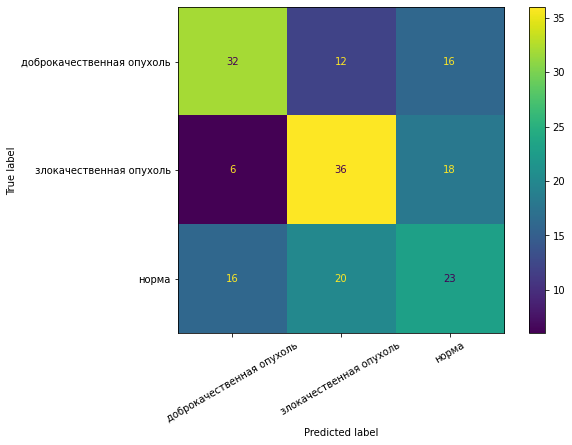

                           precision    recall  f1-score   support

доброкачественная опухоль       0.59      0.53      0.56        60
  злокачественная опухоль       0.53      0.60      0.56        60
                    норма       0.40      0.39      0.40        59

                 accuracy                           0.51       179
                macro avg       0.51      0.51      0.51       179
             weighted avg       0.51      0.51      0.51       179



In [15]:
y_pred = tree.predict(X_LE_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred))

## Label Encoding ранговых и One-Hot Encoding категориальных признаков

In [16]:
X_OHE = X.copy()

X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_3], prefix='вопрос3')], axis=1).drop([defs.QUESTION_3], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_23], prefix='вопрос23')], axis=1).drop([defs.QUESTION_23], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_25], prefix='вопрос25')], axis=1).drop([defs.QUESTION_25], axis=1)

In [17]:
X_OHE_train, X_OHE_test, y_train, y_test = train_test_split(
    X_OHE, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [18]:
tree = cross_validation(PARAM_GRID, X_OHE_train, y_train)

Лучшие гиперпараметры:
min_samples_leaf: 1
min_samples_split: 8


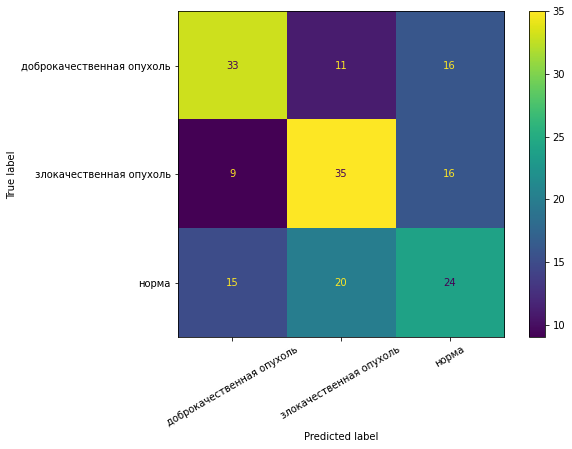

                           precision    recall  f1-score   support

доброкачественная опухоль       0.58      0.55      0.56        60
  злокачественная опухоль       0.53      0.58      0.56        60
                    норма       0.43      0.41      0.42        59

                 accuracy                           0.51       179
                macro avg       0.51      0.51      0.51       179
             weighted avg       0.51      0.51      0.51       179



In [19]:
y_pred = tree.predict(X_OHE_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))

## One-Hot Encoding категориальных и ранговых признаков

In [20]:
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_5], prefix='вопрос5')], axis=1).drop([defs.QUESTION_5], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_7], prefix='вопрос7')], axis=1).drop([defs.QUESTION_7], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_9], prefix='вопрос9')], axis=1).drop([defs.QUESTION_9], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_11], prefix='вопрос11')], axis=1).drop([defs.QUESTION_11], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_12], prefix='вопрос12')], axis=1).drop([defs.QUESTION_12], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_13], prefix='вопрос13')], axis=1).drop([defs.QUESTION_13], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_14], prefix='вопрос14')], axis=1).drop([defs.QUESTION_14], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_19], prefix='вопрос19')], axis=1).drop([defs.QUESTION_19], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_20], prefix='вопрос20')], axis=1).drop([defs.QUESTION_20], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_26], prefix='вопрос26')], axis=1).drop([defs.QUESTION_26], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_27], prefix='вопрос27')], axis=1).drop([defs.QUESTION_27], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_28], prefix='вопрос28')], axis=1).drop([defs.QUESTION_28], axis=1)
X_OHE = pd.concat([X_OHE, pd.get_dummies(X_OHE[defs.QUESTION_29], prefix='вопрос29')], axis=1).drop([defs.QUESTION_29], axis=1)

In [21]:
X_OHE_train, X_OHE_test, y_train, y_test = train_test_split(
    X_OHE, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [22]:
tree = cross_validation(PARAM_GRID, X_OHE_train, y_train)

Лучшие гиперпараметры:
min_samples_leaf: 32
min_samples_split: 128


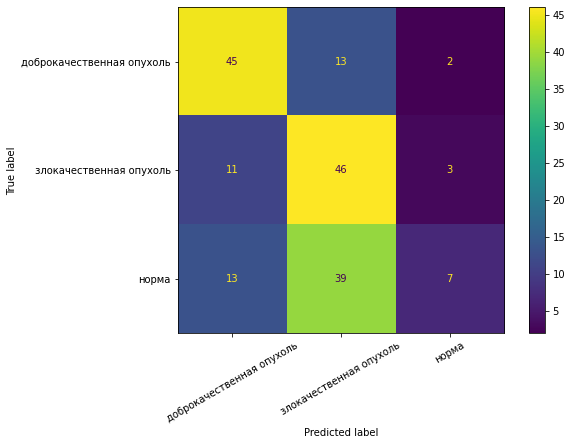

                           precision    recall  f1-score   support

доброкачественная опухоль       0.65      0.75      0.70        60
  злокачественная опухоль       0.47      0.77      0.58        60
                    норма       0.58      0.12      0.20        59

                 accuracy                           0.55       179
                macro avg       0.57      0.55      0.49       179
             weighted avg       0.57      0.55      0.49       179



In [23]:
y_pred = tree.predict(X_OHE_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))

## Multi-Class Target Encoding категориальных и Label Encoding ранговых признаков

In [24]:
def multiclass_target_encode(X, y, feature_name):
    X = X.copy()
    y_OHE = pd.get_dummies(y)
    for class_ in y_OHE.columns:
        tmp = pd.DataFrame(index=X.index)
        feature_values = X[feature_name].unique()
        for feature_value in feature_values:
            if feature_value is np.NaN:
                a = X.loc[X[feature_name].isna()].index  # точки с NaN
                tmp.loc[a, f'{feature_name}_{class_}'] = -1
            else:
                a = X[X[feature_name] == feature_value].index  # точки с определённым значением признака
                b = y_OHE[y_OHE[class_] == 1].index  # точки с определённым классом
                c = a.intersection(b)  # пересечение этих множеств точек

                tmp.loc[a, f'{feature_name}_{class_}'] = len(c) / len(X.index)
        X = pd.concat([X, tmp], axis=1)

    return X

In [25]:
X_TE = X.copy()

for feature in defs.CATEGORICAL_FEATURES:
    X_TE = multiclass_target_encode(X_TE, y, feature)
    X_TE = X_TE.drop(feature, axis=1)

In [26]:
X_TE_train, X_TE_test, y_train, y_test = train_test_split(
    X_TE, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [27]:
tree = cross_validation(PARAM_GRID, X_TE_train, y_train)

Лучшие гиперпараметры:
min_samples_leaf: 2
min_samples_split: 4


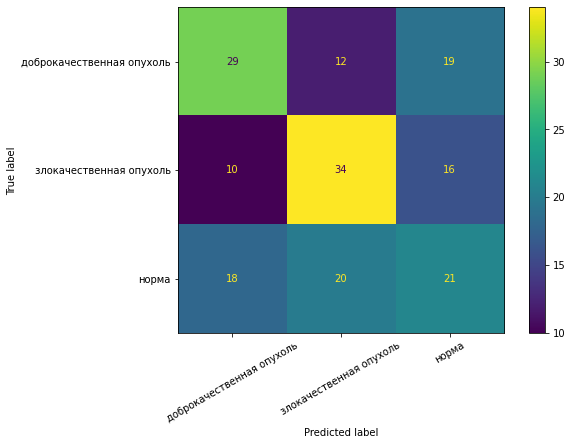

                           precision    recall  f1-score   support

доброкачественная опухоль       0.51      0.48      0.50        60
  злокачественная опухоль       0.52      0.57      0.54        60
                    норма       0.38      0.36      0.37        59

                 accuracy                           0.47       179
                macro avg       0.47      0.47      0.47       179
             weighted avg       0.47      0.47      0.47       179



In [28]:
y_pred = tree.predict(X_TE_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))

## Multi-Class Target Encoding категориальных и ранговых признаков

In [29]:
for feature in defs.RANK_FEATURES:
    X_TE = multiclass_target_encode(X_TE, y, feature)
    X_TE = X_TE.drop(feature, axis=1)

In [30]:
X_TE_train, X_TE_test, y_train, y_test = train_test_split(
    X_TE, y,
    train_size=TRAIN_SIZE,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [31]:
tree = cross_validation(PARAM_GRID, X_TE_train, y_train)

Лучшие гиперпараметры:
min_samples_leaf: 8
min_samples_split: 32


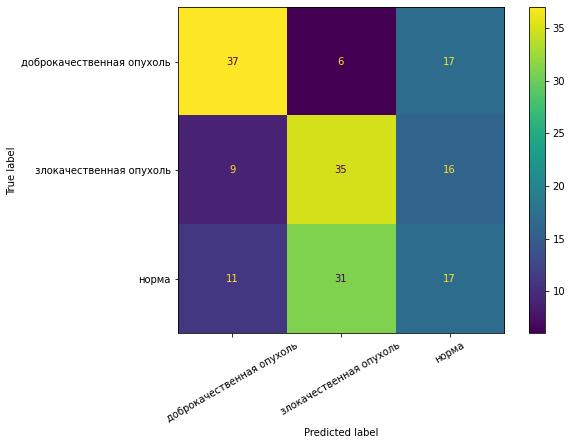

                           precision    recall  f1-score   support

доброкачественная опухоль       0.65      0.62      0.63        60
  злокачественная опухоль       0.49      0.58      0.53        60
                    норма       0.34      0.29      0.31        59

                 accuracy                           0.50       179
                macro avg       0.49      0.50      0.49       179
             weighted avg       0.49      0.50      0.49       179



In [32]:
y_pred = tree.predict(X_TE_test)

fig, ax = plt.subplots(figsize=(9, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

print(classification_report(y_test, y_pred))